Imports are important

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 2.4 MB/s eta 0:00:00


In [3]:
import re
import os
import openai
import pandas as pd
from bertopic import BERTopic
from typing import List, Optional, Set
from IPython.display import Image, display
from sentence_transformers import SentenceTransformer
import random
import numpy as np
from bertopic.representation import MaximalMarginalRelevance
from umap import UMAP
import torch
from sklearn.feature_extraction.text import CountVectorizer
import umap, hdbscan

/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [4]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech
from bertopic.vectorizers import ClassTfidfTransformer

# Hi! 🖖


## Lucija (Krušić) Brozić

Department of Digital Humanities, Uni Graz

Write me an email: lucija.krusic@uni-graz.at

Find me on GitHub: https://github.com/lucijakrusic

# How can we fine-tune the topic modelling workflow with BERTopic?


## 1. *What* is fine-tuning (in supervised approaches)?

- normally, when we think about supervised learning Normally, when we talk about supervised learning, we mean training a model on labeled data to make accurate predictions.

- in large language models like BERT or GPT, fine-tuning means taking a model that has already learned general language patterns by being trained on a lot of unlabeled data and coninuing training with a smaller corpus of labelled data for a specific task, such as sentiment analysis or text classification

- task: specific prediction/classification


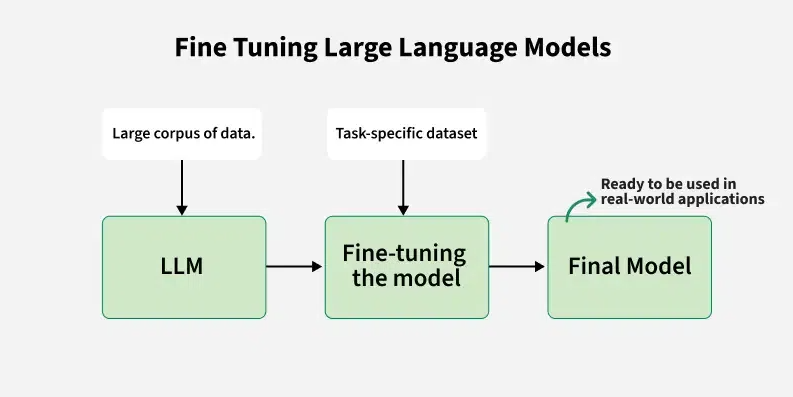

In [5]:
display(Image(filename="/content/drive/MyDrive/clariah2025-dse-ml/materials/2025-09-11_thursday/img/fine-tuning1.png"))


## 2. *How* is fine-tuning in BERTopic different?

* BERTopic is not a deep learning model trained end-to-end — it’s a modular
pipeline that uses existing tools like embeddings, clustering, and topic representation

* When we say “fine-tuning” in BERTopic, we usually mean adapting one or more of its parts to fit our data better and our task better (e.g. the embedding model)

* For example, we can fine-tune a sentence embedding model (like a SentenceTransformer) on domain-specific texts, and then use it inside BERTopic for better topic quality

* But the BERTopic model itself is unsupervised

* BERTopic fine-tuning is not the same as fine-tuning a neural model like BERT It’s more about improving components rather than retraining the whole model

* task: topic discovery


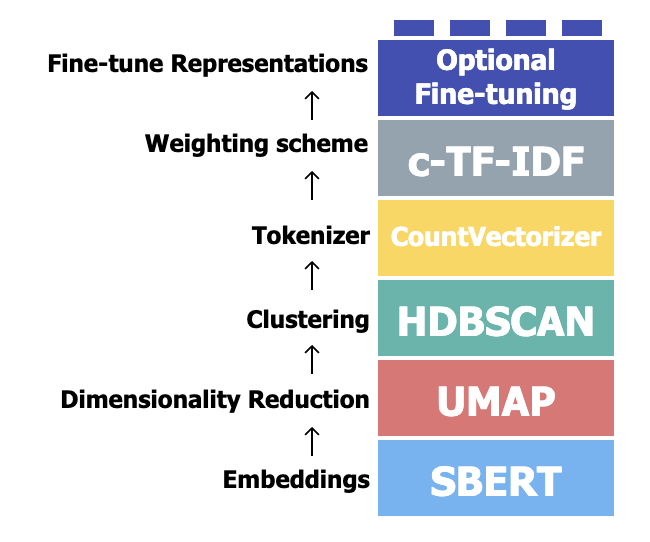

In [6]:
display(Image(filename="/content/drive/MyDrive/clariah2025-dse-ml/materials/2025-09-11_thursday/img/bertopic-fine-tuning.png"))


## 3. Let's import the Parlamint data

In [7]:
parlamint_corpus = pd.read_csv('/content/drive/MyDrive/clariah2025-dse-ml/materials/datasets/parlamint/parlamint-it-is-2022.txt', sep="\t")

In [8]:
parlamint_corpus

ID  \
0                       ParlaMint-IS_2022-01-17-20.seg2.1   
1                       ParlaMint-IS_2022-01-17-20.seg3.1   
2                       ParlaMint-IS_2022-01-17-20.seg4.1   
3                       ParlaMint-IS_2022-01-17-20.seg6.1   
4                       ParlaMint-IS_2022-01-17-20.seg7.1   
...                                                   ...   
160540  ParlaMint-IT_2022-09-20-LEG18-Senato-sed-465.a...   
160541  ParlaMint-IT_2022-09-20-LEG18-Senato-sed-465.a...   
160542  ParlaMint-IT_2022-09-20-LEG18-Senato-sed-465.a...   
160543  ParlaMint-IT_2022-09-20-LEG18-Senato-sed-465.a...   
160544  ParlaMint-IT_2022-09-20-LEG18-Senato-sed-465.a...   

                                                Parent_ID  \
0                           ParlaMint-IS_2022-01-17-20.u1   
1                           ParlaMint-IS_2022-01-17-20.u1   
2                           ParlaMint-IS_2022-01-17-20.u1   
3                           ParlaMint-IS_2022-01-17-20.u1   
4                           ParlaMint-IS_2022-01-17-20.u1   
...                                                   ...   
160540  ParlaMint-IT_2022-09-20-LEG18-Senato-sed-465.a...   
160541  ParlaMint-IT_2022-09-20-LEG18-Senato-sed-465.a...   
160542  ParlaMint-IT_2022-09-20-LEG18-Senato-sed-465.a...   
160543  ParlaMint-IT_2022-09-20-LEG18-Senato-sed-465.a...   
160544  ParlaMint-IT_2022-09-20-LEG18-Senato-sed-465.a...   

                                                     Text  
0                 President of the United States reports:  
1       I have decided, according to the proposal of t...  
2                      Arrange sites, January 11th, 2022.  
3                         Katrín Jakobsdóttir's daughter.  
4       Presidential Letters for a meeting of the Gene...  
...                                                   ...  
160540  I would say that we can consider the work of t...  
160541  Of course, all good intentions about Parliamen...  
160542  The motions, questions and questions received ...  
160543               The Senate is summoned to the house.  
160544               The sitting was closed at 16.48 p.m.  

[160545 rows x 3 columns]

### Let's check if we have any empty cells in the Text column:

We need to check for empty cells in the text column because BERTopic requires meaningful textual input for embedding and clustering, and empty entries can cause errors or distort topic modeling results.

In [9]:
n_nan = parlamint_corpus["Text"].isna().sum()
print(f"Nr of empty rows in 'Text': {n_nan}")


Nr of empty rows in 'Text': 0


### Let's create a date column (we'll need it for later):

This extracts the date in YYYY-MM-DD format from each ID string (e.g. "ParlaMint-IS_2022-01-17-20.seg2.1") using a regular expression and stores it in a new Date column.


Regex:
- \d{4} matches exactly 4 digits (the year)

- `-`   matches a literal hyphen

- \d{2} matches exactly 2 digits (the month)

-  `-`    matches the second literal hyphen

- \d{2} matches 2 digits (the day)

In [10]:
parlamint_corpus["Date"] = parlamint_corpus["ID"].apply(lambda x: re.search(r"\d{4}-\d{2}-\d{2}", x).group() if pd.notnull(x) else None)

In [11]:
parlamint_corpus["Date"] = pd.to_datetime(parlamint_corpus["Date"])

In [12]:
parlamint_corpus

ID  \
0                       ParlaMint-IS_2022-01-17-20.seg2.1   
1                       ParlaMint-IS_2022-01-17-20.seg3.1   
2                       ParlaMint-IS_2022-01-17-20.seg4.1   
3                       ParlaMint-IS_2022-01-17-20.seg6.1   
4                       ParlaMint-IS_2022-01-17-20.seg7.1   
...                                                   ...   
160540  ParlaMint-IT_2022-09-20-LEG18-Senato-sed-465.a...   
160541  ParlaMint-IT_2022-09-20-LEG18-Senato-sed-465.a...   
160542  ParlaMint-IT_2022-09-20-LEG18-Senato-sed-465.a...   
160543  ParlaMint-IT_2022-09-20-LEG18-Senato-sed-465.a...   
160544  ParlaMint-IT_2022-09-20-LEG18-Senato-sed-465.a...   

                                                Parent_ID  \
0                           ParlaMint-IS_2022-01-17-20.u1   
1                           ParlaMint-IS_2022-01-17-20.u1   
2                           ParlaMint-IS_2022-01-17-20.u1   
3                           ParlaMint-IS_2022-01-17-20.u1   
4                           ParlaMint-IS_2022-01-17-20.u1   
...                                                   ...   
160540  ParlaMint-IT_2022-09-20-LEG18-Senato-sed-465.a...   
160541  ParlaMint-IT_2022-09-20-LEG18-Senato-sed-465.a...   
160542  ParlaMint-IT_2022-09-20-LEG18-Senato-sed-465.a...   
160543  ParlaMint-IT_2022-09-20-LEG18-Senato-sed-465.a...   
160544  ParlaMint-IT_2022-09-20-LEG18-Senato-sed-465.a...   

                                                     Text       Date  
0                 President of the United States reports: 2022-01-17  
1       I have decided, according to the proposal of t... 2022-01-17  
2                      Arrange sites, January 11th, 2022. 2022-01-17  
3                         Katrín Jakobsdóttir's daughter. 2022-01-17  
4       Presidential Letters for a meeting of the Gene... 2022-01-17  
...                                                   ...        ...  
160540  I would say that we can consider the work of t... 2022-09-20  
160541  Of course, all good intentions about Parliamen... 2022-09-20  
160542  The motions, questions and questions received ... 2022-09-20  
160543               The Senate is summoned to the house. 2022-09-20  
160544               The sitting was closed at 16.48 p.m. 2022-09-20  

[160545 rows x 4 columns]

Just to double check if we actually changed it:

In [13]:
print(parlamint_corpus["Date"].dtype)


datetime64[ns]


## 4. BERTopic pipeline

- when working with BERTopic we can either 'leave it alone' and use it out of the box, or use the hyperparaeters to tune it for our use case

- out of the box would mean just trying out the

In [14]:
docs = parlamint_corpus["Text"].tolist()
print(f"Number of documents: {len(docs)}")


Number of documents: 160545


Training the base model:

In [ ]:
base_topic_model = BERTopic()
topics, probs = base_topic_model.fit_transform(docs)

In [ ]:
topic_info = base_topic_model.get_topic_info()
topic_info.head(15)

Topic  Count                                               Name  \
0      -1  71540                                    -1_and_in_of_it   
1       0   2570                  0_italy_italian_italians_brothers   
2       1   1720                      1_bill_bills_changes_suggests   
3       2   1422              2_council_councils_councilmen_members   
4       3   1185                 3_ukraine_russia_russian_ukrainian   
5       4   1075                      4_senator_senators_agree_hear   
6       5    961                        5_bank_banks_banking_office   
7       6    920  6_parliament_parliamentary_parliaments_parliam...   
8       7    908                       7_fishing_fish_coastal_catch   
9       8    820            8_child_children_childrens_childwelfare   
10      9    810         9_mental_mentalhealth_health_psychological   
11     10    734                             10_law_laws_legal_code   
12     11    734              11_school_teachers_students_education   
13     12    720                      12_explanation_speak_ask_vote   
14     13    699                13_pension_pensions_fund_pensioners   

                                       Representation  \
0       [and, in, of, it, the, to, be, we, that, are]   
1   [italy, italian, italians, brothers, italia, f...   
2   [bill, bills, changes, suggests, change, contr...   
3   [council, councils, councilmen, members, here,...   
4   [ukraine, russia, russian, ukrainian, putin, i...   
5   [senator, senators, agree, hear, what, why, id...   
6   [bank, banks, banking, office, county, collaps...   
7   [parliament, parliamentary, parliaments, parli...   
8   [fishing, fish, coastal, catch, farming, beach...   
9   [child, children, childrens, childwelfare, par...   
10  [mental, mentalhealth, health, psychological, ...   
11  [law, laws, legal, code, these, effect, curren...   
12  [school, teachers, students, education, traini...   
13  [explanation, speak, ask, vote, you, an, for, ...   
14  [pension, pensions, fund, pensioners, pensione...   

                                  Representative_Docs  
0   [When can we get to a place where we can do mo...  
1   [Mr President, the Brothers of Italy Group wil...  
2   [But there is no such law for going on that bi...  
3   [But I just hope that we here at the council w...  
4   [It is difficult not to see in the Russian inv...  
5   [I couldn't agree more. Senator., I have to ag...  
6   [We can talk about community banks, and, of co...  
7   [They do not think so, but we see in the vote ...  
8   [We are going to have one price today, actuall...  
9   [I think the approach in this case needs to be...  
10  [Mental health is the basis for the general we...  
11  [Therefore, these laws must be followed., That...  
12  [And I take the school as an example., And the...  
13  [I ask you to speak for an explanation of vote...  
14  [I came a little bit into it earlier when we w...

How many topics did we get?

In [ ]:
len(topic_info)

1277

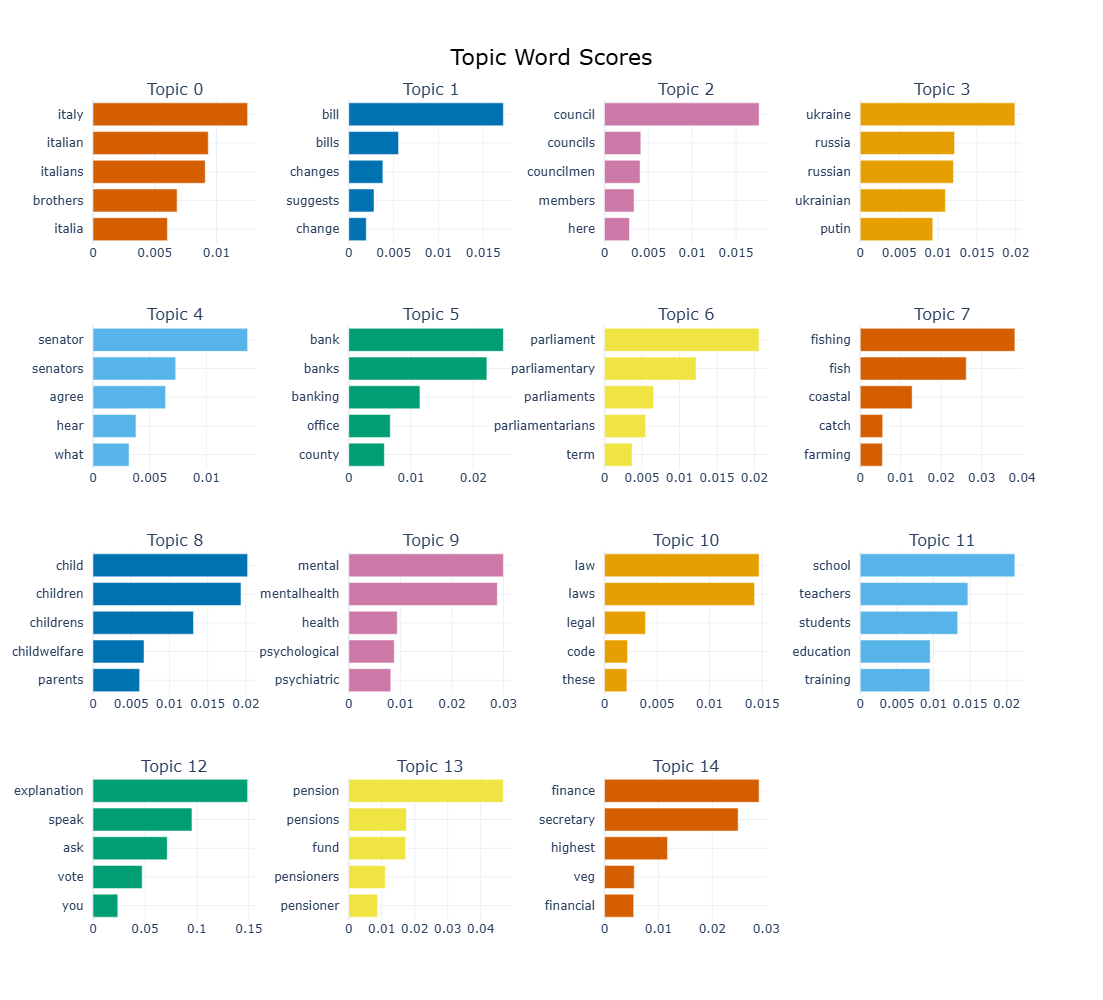

In [ ]:
base_topic_model.visualize_barchart(top_n_topics=15)

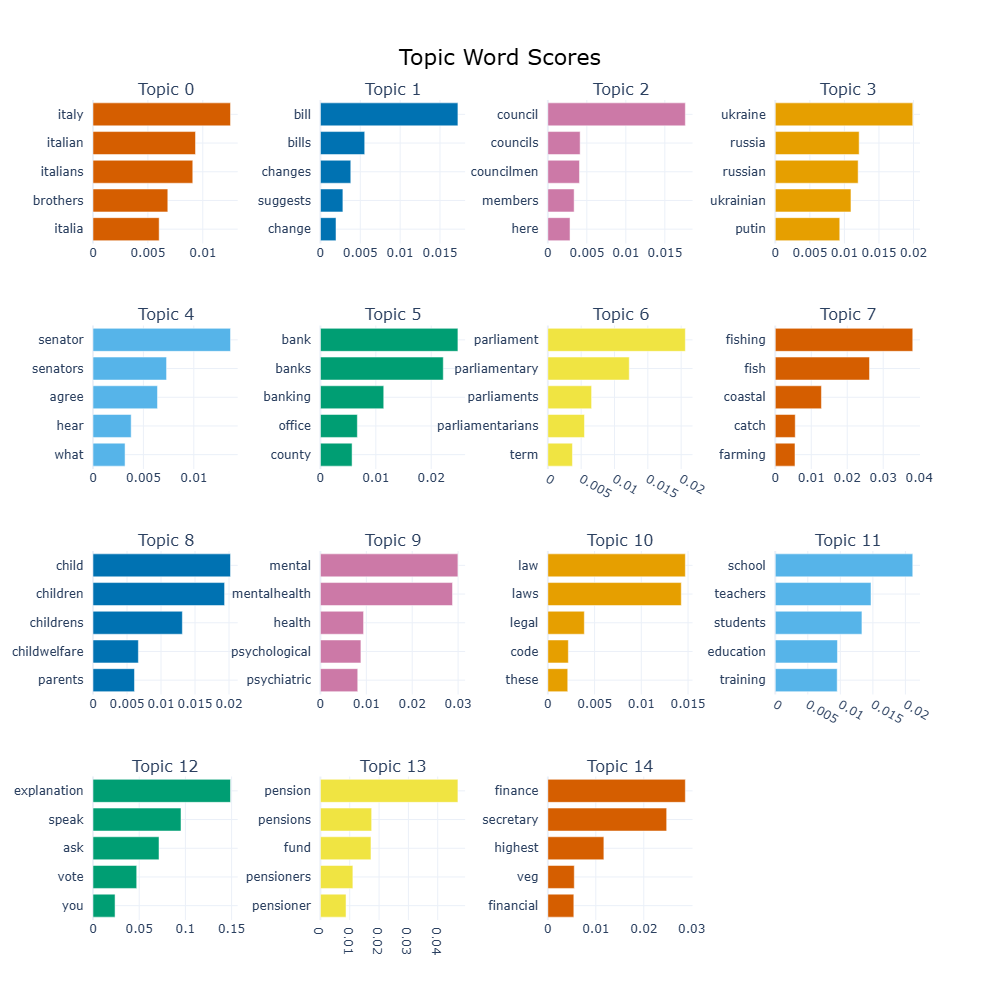

In [16]:
display(Image(filename="/content/drive/MyDrive/clariah2025-dse-ml/materials/2025-09-11_thursday/img/plt1.png"))


In [ ]:
parlamint_corpus["Topic"] = topics

# save to file
parlamint_corpus.to_csv("parlamint_with_topics.csv", index=False)

In [ ]:
base_topic_model.save("parlamint_base.mm", save_embedding_model=True)


2025-09-10 18:33:59,930 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
C:\Users\krusic\AppData\Local\anaconda3\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



## 5. BERTopic hyperparameter tuning

### <b>BERTopic</b>

- **language**  
  Although `language` is now an optional parameter in BERTopic (v0.14.0+), it is used **only** to configure the stopword list for the internal `CountVectorizer` if no `vectorizer_model` is explicitly defined[^1].  
  - `"english"` applies the default English stopwords from scikit-learn  
  - `"multilingual"` results in **no stopword filtering** (as multilingual stopword lists are not supported natively)  
  This parameter does **not** change the embedding model, tokenizer, or vectorization logic. To properly model different languages, you must explicitly choose a suitable `embedding_model`.  
  - English model: `"all-MiniLM-L6-v2"` (default)  
  - Multilingual model: `"paraphrase-multilingual-MiniLM-L12-v2"`

- **top_n_words** (default: `10`)  
  Specifies how many of the top-ranked keywords per topic are retained and displayed in summaries, visualizations, and `.get_topic()` outputs.  
  Higher values (e.g., 15–20) can help in detailed analysis or human interpretation of overlapping topics; lower values make visualizations less cluttered.

- **n_gram_range** (default: `(1, 1)`)  
  Defines the range of n-grams (word sequences) used when extracting topic representations.  
  For example:  
  - `(1, 1)` uses only single words  
  - `(1, 2)` includes unigrams and bigrams ("climate", "climate change")  
  - `(1, 3)` adds trigrams ("climate change policy")  
  This is especially useful for identifying phrases in formal, structured texts like parliamentary debates.

- **min_topic_size** (default: `10`)  
  Sets the minimum number of documents required to form a valid topic cluster.  
  Topics with fewer than this number of documents are either discarded or merged.  
  Use higher values (e.g., 30–50) to extract stable, interpretable macro-topics; use lower values (e.g., 5–10) for fine-grained or exploratory topic discovery.

- **nr_topics** (default: `None`)  
  Optional parameter to **manually reduce** the number of topics *after* the initial clustering has taken place.  
  If set to an integer (e.g., `nr_topics=20`), BERTopic merges similar topics using class-based reduction to fit the desired number.  
  This is helpful when the automatically detected number of topics is too large or fragmented.

- **low_memory** (default: `False`)  
  When `True`, BERTopic does **not** store document embeddings in memory during training. Instead, it re-computes them as needed, reducing RAM usage at the cost of slower post-hoc operations (e.g., `.transform()` or `.visualize_documents()`).  
  This is especially useful when working with large corpora or in memory-constrained environments like Google Colab.

- **calculate_probabilities** (default: `False`)  
  If enabled, BERTopic returns a **soft probability distribution** over all topics for each document, instead of just a single hard assignment.  
  This allows for more nuanced interpretations, especially in corpora where texts may involve multiple overlapping themes.  
  It is slightly more computationally expensive but useful for analyzing **topic uncertainty** or for **document )` when no `vectorizer_model` is passed.
dding_model` and the tokenizer used in `vectorizer_model`.
data

Let's start by exchanging the embedding model. You can use any embedding model or one from their list. We can try the best one (very slow though). This is still a sentence embedding model!

Models to look through: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

In [ ]:
embedding_model = SentenceTransformer("all-mpnet-base-v2")
emb_topic_model = BERTopic(embedding_model=embedding_model)
topics, probs = emb_topic_model.fit_transform(docs)


In [ ]:
topic_info = emb_topic_model.get_topic_info()
topic_info.head(15)

Topic  Count                                            Name  \
0      -1  86001                              -1_we_this_it_that   
1       0   1782                0_paritaprevir_son_ingi_daughter   
2       1   1716           1_minister_ministers_highest_ministry   
3       2   1428                 2_housing_rent_apartments_homes   
4       3   1205                  3_ukraine_russia_putin_russian   
5       4   1086               4_italians_italy_italian_brothers   
6       5   1035         5_energy_renewable_electricity_exchange   
7       6    961                     6_bank_banks_banking_office   
8       7    930                      7_senator_why_question_ask   
9       8    899                      8_bill_bills_articles_good   
10      9    863            9_school_students_education_teachers   
11     10    820                  10_fishing_fish_coastal_marine   
12     11    781                11_epidemic_pandemic_covid_virus   
13     12    725                   12_explanation_speak_ask_vote   
14     13    707  13_government_governments_trust_responsibility   

                                       Representation  \
0   [we, this, it, that, and, have, in, be, are, not]   
1   [paritaprevir, son, ingi, daughter, jóhannsson...   
2   [minister, ministers, highest, ministry, prime...   
3   [housing, rent, apartments, homes, apartment, ...   
4   [ukraine, russia, putin, russian, ukrainian, i...   
5   [italians, italy, italian, brothers, viva, fav...   
6   [energy, renewable, electricity, exchange, sou...   
7   [bank, banks, banking, office, sale, collapse,...   
8   [senator, why, question, ask, what, senators, ...   
9   [bill, bills, articles, good, main, this, thin...   
10  [school, students, education, teachers, univer...   
11  [fishing, fish, coastal, marine, farms, farmin...   
12  [epidemic, pandemic, covid, virus, 19, spread,...   
13  [explanation, speak, ask, vote, you, an, for, ...   
14  [government, governments, trust, responsibilit...   

                                  Representative_Docs  
0   [I find it very difficult for us to set our co...  
1   [I want to thank you. paritaprevir Andrés Ingi...  
2   [To answer, financial and economic ministers, ...  
3   [Inflation is 5.7% , but without housing, it w...  
4   [The people in Russia don't want war., Russia'...  
5   [Brothers of Italy tell you what responsibilit...  
6   [How much do we need in our energy exchange?, ...  
7   [There's a lot of people at the bank., Such la...  
8   [Thank you. A senator for the question., I'd l...  
9   [This bill is just not about it at all., That'...  
10  [How important it is to have discussions with ...  
11  [Coastal fishing, however, has given rise to m...  
12  [I hope we can see the end of this epidemic., ...  
13  [I ask you to speak for an explanation of vote...  
14  [But what will the government do?, And what wi...

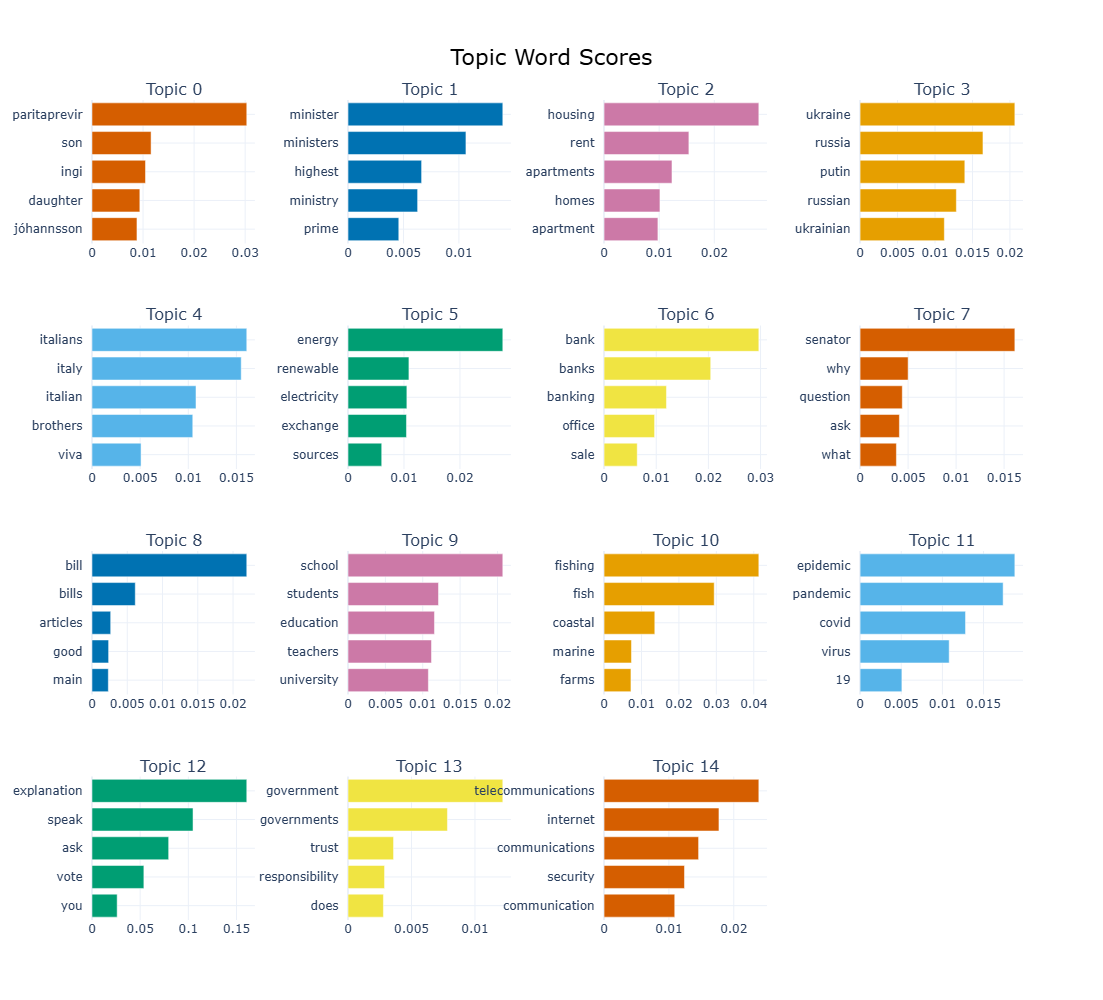

In [ ]:
emb_topic_model.visualize_barchart(top_n_topics=15)

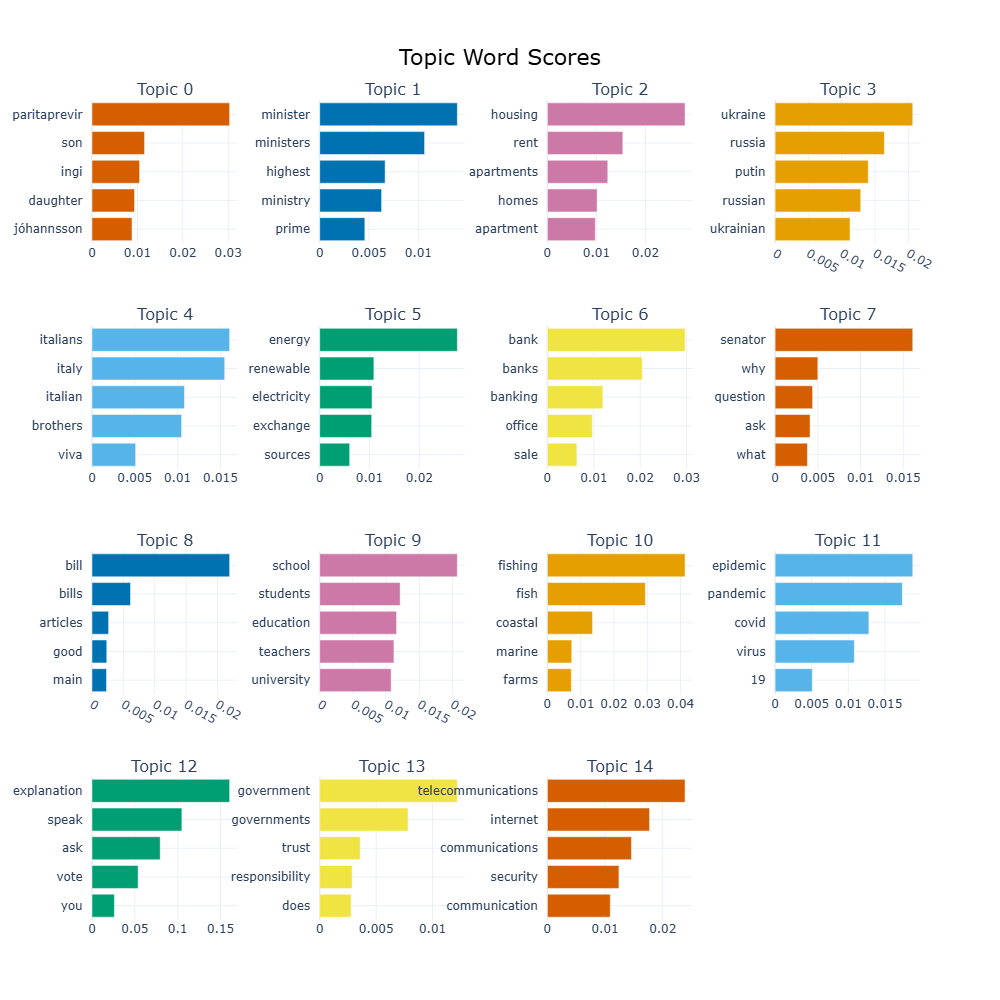

In [17]:
display(Image(filename="/content/drive/MyDrive/clariah2025-dse-ml/materials/2025-09-11_thursday/img/plt2.png"))


In [ ]:
emb_topic_model.save("parlamint_emb.mm", save_embedding_model=True)


2025-09-10 18:39:08,341 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
C:\Users\krusic\AppData\Local\anaconda3\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



### <b>UMAP</b> (Dimensionality Reduction)

- **n_neighbors** (default: `15`)  
  Controls local/global structure balance. Lower values = fine local clusters; higher = global structure.

- **n_components** (default: `5`)  
  Number of dimensions to reduce embeddings to. Usually between 2–15.

- **metric** (default: `"cosine"`)  
  Distance function used to compute similarity between embeddings.

- **low_memory** (default: `False`)  
  Enables memory-efficient computation (affects speed and caching).



### <b>HDBSCAN</b> (Clustering Algorithm)

- **min_cluster_size** (default: `10`)  
  Minimum size of a topic cluster. Smaller values allow finer granularity.

- **min_samples** (default: `None`)  
  Higher values increase robustness; defaults to `min_cluster_size` if not set.

- **metric** (default: `"euclidean"` unless overridden by BERTopic)  
  Distance function used in clustering. `"cosine"` is typically passed through from UMAP.

- **prediction_data** (default: `True`)  
  Enables `.transform()` on unseen data. Disable only if no future prediction is needed.

## Example 1 - Large topics

- increased the n_neighbours to encompass global structure

In [ ]:
um = umap.UMAP(n_neighbors=50, n_components=5, min_dist=0.1, metric="cosine", random_state=42)

- increased min_cluster size to increase granularity and min_samples
- setting min_samples significanlty lower than min_cluster size might help reduce outliers

In [ ]:
cl = hdbscan.HDBSCAN(min_cluster_size=60, min_samples=20, metric="euclidean", prediction_data=True)

- added ngram possibiity (captures single and two word phrases), removed stopwords  

In [ ]:
vec = CountVectorizer(ngram_range=(1,2),stop_words='english' )

- top_n_words= 15, meaning every topic will be described by 10 words

In [ ]:
example1_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=um,
    hdbscan_model=cl,
    vectorizer_model=vec,
    top_n_words=15,
    min_topic_size=60,
    nr_topics=None,
    calculate_probabilities=False,
    low_memory=False
)


In [ ]:
topics, probs = example1_model.fit_transform(docs)


In [ ]:
topic_info = example1_model.get_topic_info()
topic_info.head(15)

Topic  Count                                            Name  \
0      -1  90952                   -1_government_people_time_law   
1       0   7965      0_iceland_icelandic_paritaprevir_reykjavík   
2       1   4957                         1_think_things_don_just   
3       2   3818        2_senator_thank senator_thank_hv senator   
4       3   3506                 3_italy_italian_italians_italia   
5       4   2665   4_minister_highest_highest minister_ministers   
6       5   1607                  5_ukraine_russia_russian_putin   
7       6   1404                      6_fishing_fish_sea_coastal   
8       7   1297   7_energy_electricity_energy exchange_exchange   
9       8   1174              8_food_farmers_agriculture_organic   
10      9   1155                 9_pandemic_epidemic_covid_virus   
11     10   1054      10_mental_mental health_health_health care   
12     11   1038             11_hospital_health care_health_care   
13     12   1019                12_child_children_parents_family   
14     13    994  13_parliament_election_elections_parliamentary   

                                       Representation  \
0   [government, people, time, law, work, just, ne...   
1   [iceland, icelandic, paritaprevir, reykjavík, ...   
2   [think, things, don, just, discussion, going, ...   
3   [senator, thank senator, thank, hv senator, hv...   
4   [italy, italian, italians, italia, brothers it...   
5   [minister, highest, highest minister, minister...   
6   [ukraine, russia, russian, putin, ukrainian, w...   
7   [fishing, fish, sea, coastal, marine, coastal ...   
8   [energy, electricity, energy exchange, exchang...   
9   [food, farmers, agriculture, organic, producti...   
10  [pandemic, epidemic, covid, virus, covid 19, 1...   
11  [mental, mental health, health, health care, s...   
12  [hospital, health care, health, care, land hos...   
13  [child, children, parents, family, child prote...   
14  [parliament, election, elections, parliamentar...   

                                  Representative_Docs  
0   [There has been money added to certain aspects...  
1   [I want to thank you. paritaprevir Jóhann Páll...  
2   [I don't think there's any more to say about i...  
3   [Thank you. A senator very much., Thank you. A...  
4   [The priorities, Mr President, are only Italy ...  
5   [My question to the highest. Prime Minister......  
6   [I said here yesterday that it was admirable t...  
7   [It is only permitted to start coastal fishing...  
8   [A more simple and more reasonable system is b...  
9   [Crops, agriculture and food production need a...  
10  [As we all know, the Covid pandemic, the pande...  
11  [We need to make use of all resources and use ...  
12  [I think the history of the Land Hospital, und...  
13  [All cases of child protection and child-prote...  
14  [It's not a good position to have so short bet...

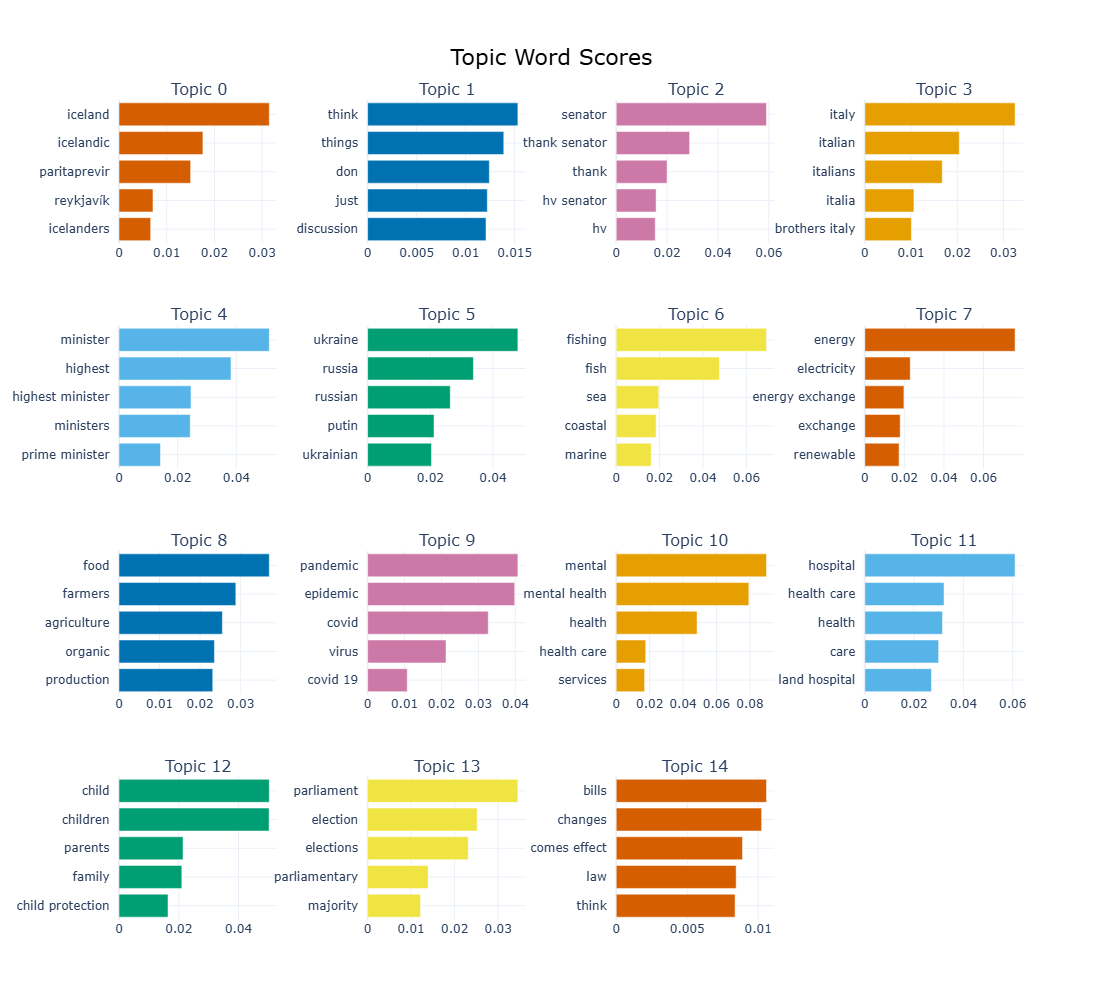

In [ ]:
example1_model.visualize_barchart(top_n_topics=15)

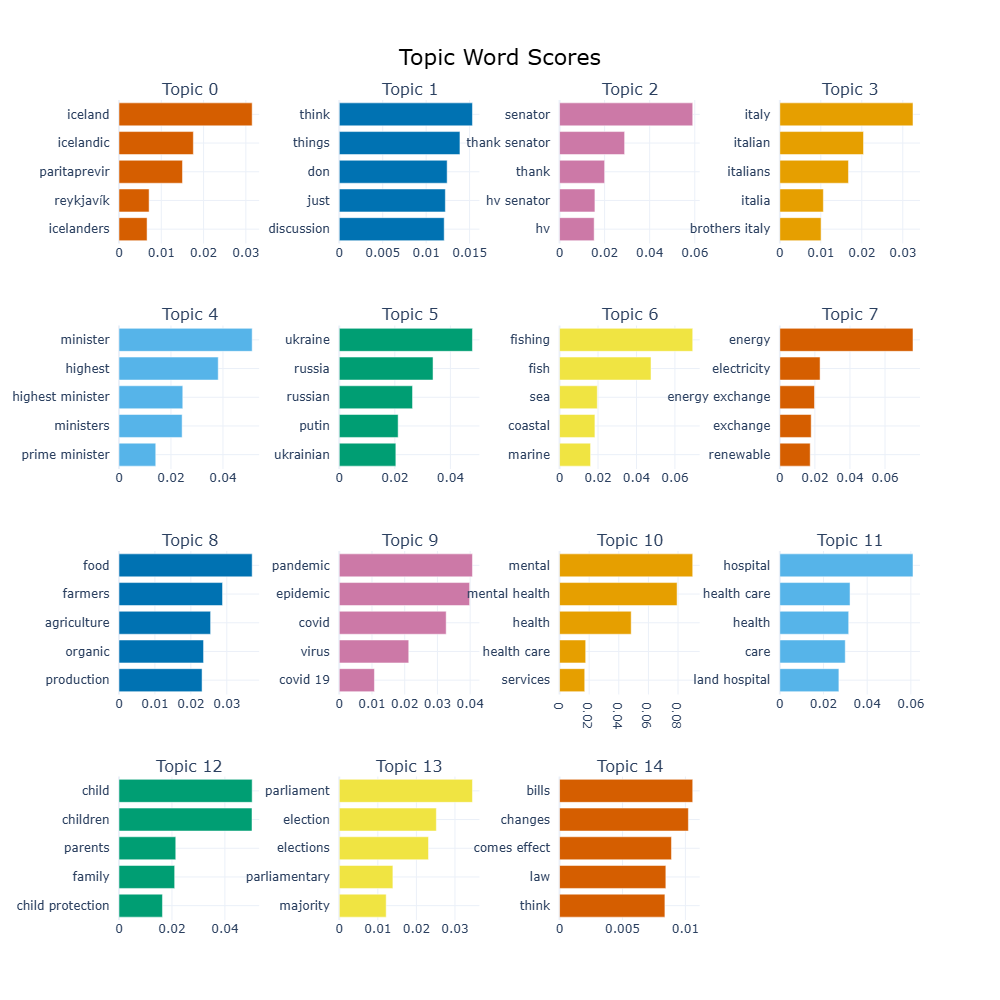

In [ ]:
display(Image(filename="/content/drive/MyDrive/clariah2025-dse-ml/materials/2025-09-11_thursday/img/plt3.png"))


In [ ]:
example1_model.save("example1.mm", save_embedding_model=True)

2025-09-10 18:45:39,808 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
C:\Users\krusic\AppData\Local\anaconda3\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



<div class="alert alert-block alert-info">
<b> Make a  model that takes into consideration speed and memory efficiency.
Some ideas as to what to change:

    
1. **Embedding Model** ().

2. **UMAP (Dimensionality Reduction)**
   - Reduce the number of **output dimensions** to make the model fster.
   - Adjust the number of **neighbors** to balance between local detail and global cohrence.
   - Enable a **memory-efficient option** to prevent caching large intermediate esults.

3. **HDBSCAN (Clustering)**
   - Choose a **moderate minimum cluster size** to avoid too many miro-topics.
   - Disable **prediction mode** to save memory if you don't plan to classify new docuents later.

4. **Vectorizer**
   - Use unigrams and bigrams to allow short kyword phrases.
   - Apply **stopword removal** to avoid meaingless topics.

5. **BERTopic Configuration**
   - Use fewer **top words per topic** to reduce pot-processing load.
   - Skip probability calculation to savetime and resources.
   - Enable **automatic topic merging** to rduce overclustering.

</p>
</div>

# 6.  Fine tuning topic representation


- in BERTopic, the default is Bag-of-Words representation and weighting with c-TF-IDF
- this can quickly generate a number of keywords for a topic
- BUT, we can <b>change</b> the way topics are represented using:
     
   
                  - MaximalMarginalRelevance
  
                  - KeyBERTInspired
  
                  - PartOfSpeech

                  - LLMs (but, mostly with APIs)

See more: https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#partofspeech
               

## MaximalMarginalRelevance             

In essence, this algorithm helps us remove similar (and redundant) topic words. It considers the similarity of the keywords with the document, along with the similarity of already selected keywords and keyphrases. This results in a selection of keywords that maximize their within diversity with respect to the document.

In [ ]:
representation_model = MaximalMarginalRelevance(diversity=0.6)


base2_topic_model = BERTopic(representation_model=representation_model)


In [ ]:
topics, probs = base2_topic_model.fit_transform(docs)

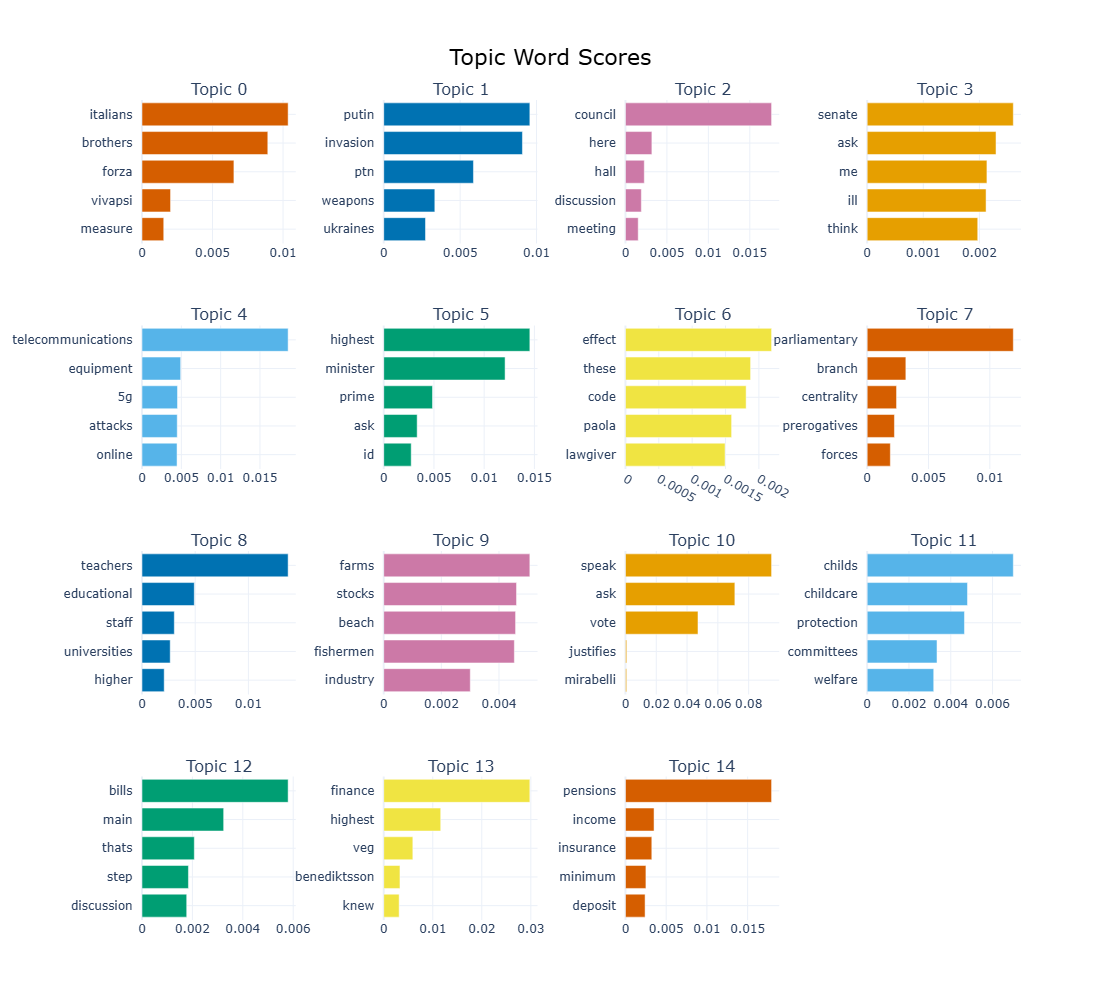

In [ ]:
base2_topic_model.visualize_barchart(top_n_topics=15)

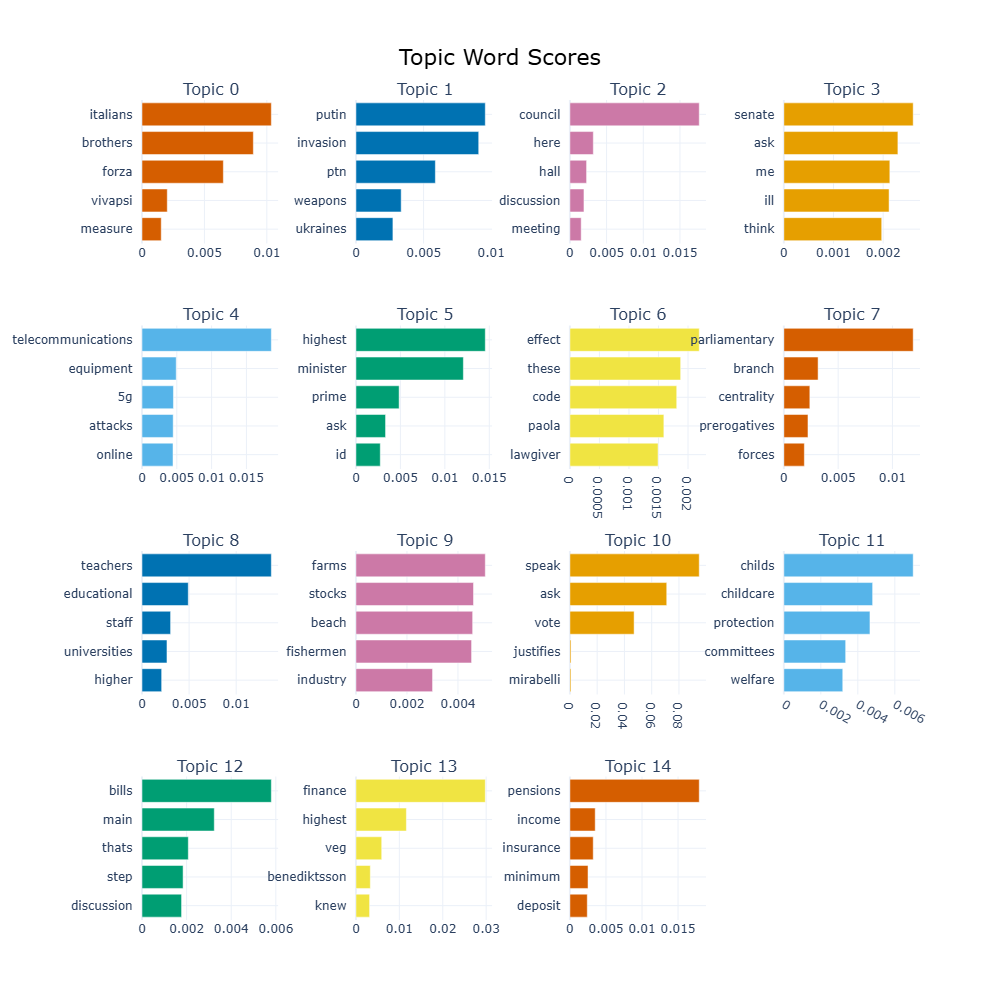

In [ ]:
display(Image(filename="/content/drive/MyDrive/clariah2025-dse-ml/materials/2025-09-11_thursday/img/plt4.png"))


<div class="alert alert-block alert-info">
<b>
Compare our initial (base model) and the topic words found in its topics with this one. What do you think, is it an improvement?
</p>
</div>

## KeyBERTInspired
 - fine-tuning based on semantic relationship between keyword and phrases and the set documents.
 - c-TF-IDF creates a set of representative documents per topic and uses those as updated topic embedding
model)`

```
from bertopic.representation import KeyBERTInspired
   

# Create your representation model
representation_model = KeyBERTInspired()

# Use the representation model in BERTopic on top of the default pipeline
base2_topic_model = BERTopic(representation_model=representation_model)

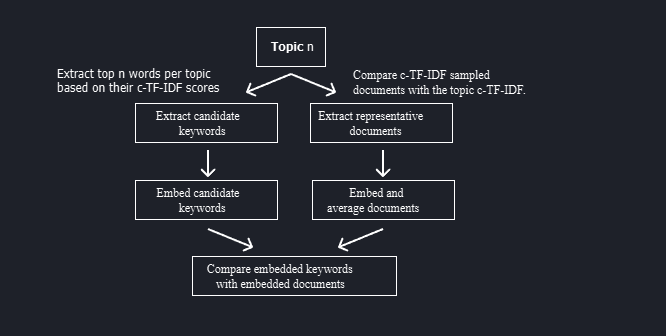

In [ ]:
display(Image(filename="img/keybert1.png"))


## POS tagging (BERTopic + spaCy)

Instead of using raw c-TF-IDF word rankings as topic labels, BERTopic can extract more **linguistically meaningful phrases** using spaCy’s **Part-of-Speech (POS)** patterns.


- BERTopic first identifies representative documents per topic using c-TF-IDF keywords.
- These documents are parsed with **spaCy's POS tagger** to extract phrases matching the following rule-based patterns:

```
DEFAULT_PATTERNS = [
    [{'POS': 'ADJ'}, {'POS': 'NOUN'}],  # e.g. "economic crisis"
    [{'POS': 'NOUN'}],                  # e.g. "inflation"
    [{'POS': 'ADJ'}]                    # e.g. "unemployed"
]
```

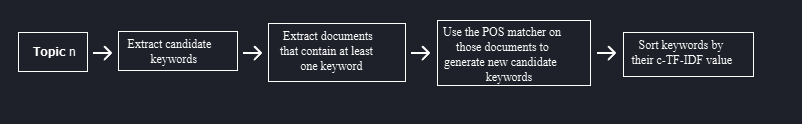

In [ ]:
display(Image(filename="img/pos.png"))


# 7. Guiding our analysis

## Seed words (semi-supervised learning)
One interesting thing about BERTopic is that we can use it to guide the topic modelling process to find certain topics we are interested in and guide our analysis.


One way this can be done is through using seed words to make sure some domain specific words are rated more highly.
This can be done by setting any number of ```seed_words``` in the ```ClassTfidfTransformer```.

Documentation: https://maartengr.github.io/BERTopic/getting_started/seed_words/seed_words.html



In [ ]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# We can choose any number of seed words for which we want their representation
# to be strengthen. We increase the importance of these words as we want them to be more
# likely to end up in the topic representations.
ctfidf_model = ClassTfidfTransformer(
    seed_words=["covid", "hospital", "mental health", "stress", "virus", "epidemic","disease"],
    seed_multiplier=5
)

# We run the topic model with the seeded words
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    min_topic_size=15,
    ctfidf_model=ctfidf_model,
).fit(docs)


In [ ]:
topic_info = topic_model.get_topic_info()


In [ ]:
topic_info.head(30)

Topic  Count                                               Name  \
0      -1  88606                   -1_hospital_stress_covid_disease   
1       0   1745                   0_paritaprevir_son_ingi_daughter   
2       1   1622                      1_senator_agree_what_senators   
3       2   1531                     2_epidemic_covid_virus_disease   
4       3   1461                     3_ukraine_russia_russian_putin   
5       4   1322                    4_housing_rent_apartments_homes   
6       5   1126                        5_bank_banks_banking_office   
7       6   1025              6_minister_ministers_ministry_highest   
8       7    970            7_energy_electricity_renewable_exchange   
9       8    848                  8_financial_budget_program_policy   
10      9    786             9_school_students_education_university   
11     10    723                      10_explanation_speak_ask_vote   
12     11    661                   11_child_children_family_parents   
13     12    648  12_telecommunications_internet_communications_...   
14     13    625                        13_peace_war_diplomacy_wars   
15     14    623                            14_bill_bills_main_this   
16     15    602                       15_council_hall_members_here   
17     16    590            16_discussion_interesting_discuss_gonna   
18     17    577        17_judiciary_magistrates_magistrate_justice   
19     18    572                  18_approves_annex_followed_senate   
20     19    569            19_sport_sports_activity_psychophysical   
21     20    563                    20_approve_annex_doesn_followed   
22     21    551                    21_fishing_fish_coastal_farming   
23     22    540                22_water_drought_irrigation_outflow   
24     23    532                        23_bank_iceland_banks_sales   
25     24    527                     24_pension_fund_pensions_funds   
26     25    524                    25_artists_art_artist_musicians   
27     26    518                 26_mental_health_hospital_services   
28     27    517      27_government_governments_does_responsibility   
29     28    505               28_iceland_icelanders_icelandic_nato   

                                       Representation  \
0   [hospital, stress, covid, disease, this, that,...   
1   [paritaprevir, son, ingi, daughter, jóhannsson...   
2   [senator, agree, what, senators, why, question...   
3   [epidemic, covid, virus, disease, pandemic, ho...   
4   [ukraine, russia, russian, putin, ukrainian, i...   
5   [housing, rent, apartments, homes, apartment, ...   
6   [bank, banks, banking, office, sale, county, s...   
7   [minister, ministers, ministry, highest, semin...   
8   [energy, electricity, renewable, exchange, ele...   
9   [financial, budget, program, policy, budgets, ...   
10  [school, students, education, university, teac...   
11  [explanation, speak, ask, vote, you, an, for, ...   
12  [child, children, family, parents, welfare, pr...   
13  [telecommunications, internet, communications,...   
14  [peace, war, diplomacy, wars, weapons, peacefu...   
15  [bill, bills, main, this, think, re, don, here...   
16  [council, hall, members, here, councilmen, at,...   
17  [discussion, interesting, discuss, gonna, talk...   
18  [judiciary, magistrates, magistrate, justice, ...   
19  [approves, annex, followed, senate, see, vote,...   
20  [sport, sports, activity, psychophysical, prac...   
21  [approve, annex, doesn, followed, senate, see,...   
22  [fishing, fish, coastal, farming, catch, farms...   
23  [water, drought, irrigation, outflow, rivers, ...   
24  [bank, iceland, banks, sales, icelandic, sale,...   
25  [pension, fund, pensions, funds, pensioner, pe...   
26  [artists, art, artist, musicians, music, enter...   
27  [mental, health, hospital, services, psychiatr...   
28  [government, governments, does, responsibility...   
29  [iceland, icelanders, icelandic, nato, nuclear...   

                                  

So, from this we see that the topics we're especially interested in are Topic 2 (epidemic), Topic 19 (sport) and Topic 26 (mental health).

## Dynamic Topic Modelling

**Dynamic Topic Modeling** aims to track how topics change over time — not in topic **presence**, but in topic **content**. For instance, while *environmental awareness* may be a recurring topic across decades, its language and framing evolve significantly.


How DTM Works in BERTopic

BERTopic supports DTM **without retraining** the model multiple times. The steps are:

1. **Train a global BERTopic model** (ignore time at this stage).
2. **Assign topics once** — these remain constant across time.
3. **Split documents** by:
   - Topic
   - Timestep (e.g., year, quarter, decade)
4. For each topic × timestep:
   - Calculate a new **c-TF-IDF** representation based only on documents from that period.



###  Fine-Tuning Temporal Representations

BERTopic allows **two types of tuning** for time-specific topic representations:

- **Global Tuning** (default: `True`)  
  - Smooths the timestep-specific representation by averaging it with the global representation.  
   - Helps stabilize noisy or sparse periods.

- **Evolutionary Tuning** (default: `True`)  
  - Adjusts each timestep’s topic representation based on its value at the previous timestep (*t − 1*).  
  - Enables **gradual topic drift** over time

In [ ]:
tot = topic_model.topics_over_time(
    docs=parlamint_corpus["Text"].tolist(),
    timestamps=parlamint_corpus["Date"].tolist(),
    global_tuning=True,
    evolution_tuning=True,
    nr_bins=9, # nine months of data
    datetime_format="%Y-%m-%d"
)


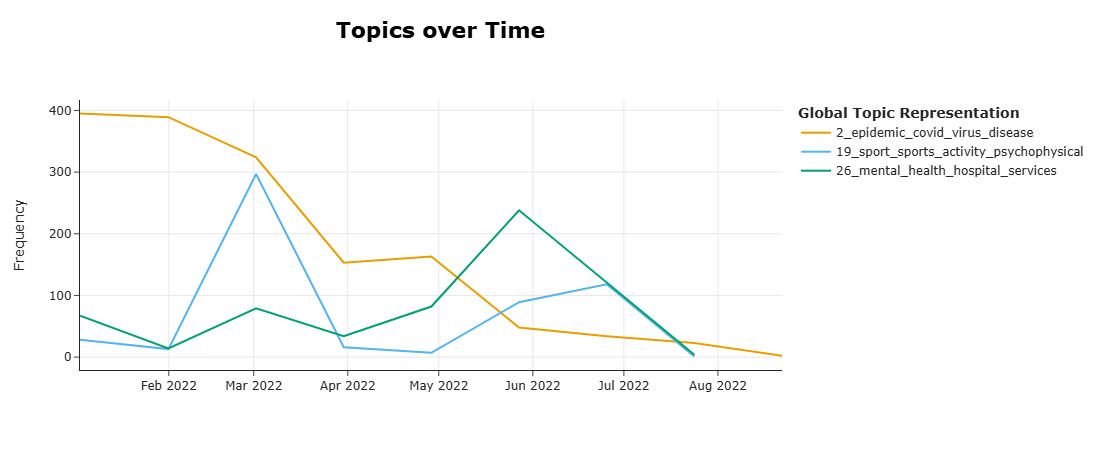

In [ ]:
topic_model.visualize_topics_over_time(tot, topics=[2, 26, 19])


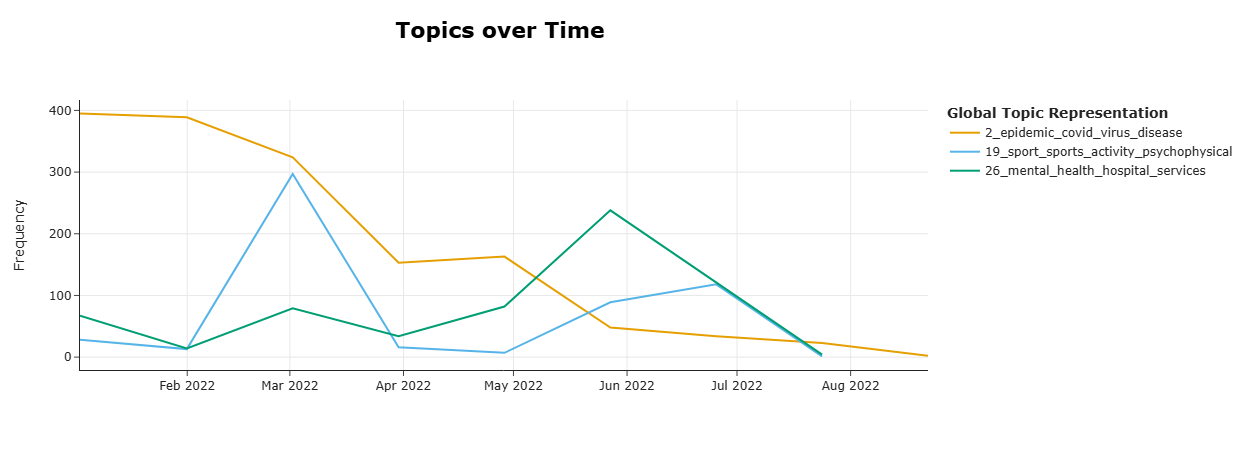

In [18]:
display(Image(filename="/content/drive/MyDrive/clariah2025-dse-ml/materials/2025-09-11_thursday/img/dtm.png"))


<div class="alert alert-block alert-info">
<b>
What can we conclude from this? How do we contextualize these results?
Try DTM out with another topic you're interested in.
</p>
</div>

# What is the potential of BERTopic fine-tuning for Digital Humanities studies?
- thesis "Sentiments towards migrants and minorities in Austrian newspapers (1700-1938)"
- Methodology:
    1. newspaper selection
    2. Topic modelling using BERTopic + seed words connected to migration, minorities and related topics
    3. Dynamic Topic Modelling
    4. Selection of relevant topics (e.g. migration, migration to the US, nationalism, Czechs, education, Labour rigths)
    5. sentiment annotation of a smaller subset
    6. sentiment classification of a larger corpus
              

# That's all for today! Thank you for listening :)